<a href="https://colab.research.google.com/github/Lopez-504/Redshift-Estimation-Using-NN/blob/main/NN_Redshift_Log_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Librerias
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

# Datos

In [3]:
df_150 = pd.read_csv(
    "/content/drive/MyDrive/Data_Share/150k.csv",skiprows=1,
    dtype={col: "float" for col in range(0, 68)}
)

print("Informacion del DataFrame: \n")
print("Tipo: ", type(df_150))
print("Forma: ", df_150.shape)

# Buscamos los valores sinteticos
df_150 = df_150.replace(-9999, np.nan)
#df_150 = df_150.replace(-1000, np.nan)

# Contamos los "Nans"
print("Total de Nans en el DataFrame: ",df_150.isna().sum().sum(),"\n")


# Quitar filas con al menos un NaN
df_150 = df_150.dropna()

# Quitamos los errores
data = df_150.drop(columns=[c for c in df_150.columns if "Err" in c], axis=1)
#data = data.drop(columns=[c for c in data.columns if "fiber" in c], axis = 1)

Informacion del DataFrame: 

Tipo:  <class 'pandas.core.frame.DataFrame'>
Forma:  (150000, 68)
Total de Nans en el DataFrame:  345 



# Caracterizaciones Importantes:

Nuestras variables de magnitud (deredMag, modelMag) y de tamaño (petroRad, expRad, deVRad) son nuestras variables más importantes para el calculo del redshift. Las magnitudes nos dicen la luminosidad del obejto la cual es una propiedad intrinseca.

Las posiciones en el cielo seran importantes a la hora de identificar objetos pero tambien pueden tener relacion con la extincion galactica.

Por ultimo las variables morfologicas estan ligadas a las propiedades fisicas del objeto y sirven para hacer correcciones, ya que el corrimiento para el tipo de galaxia es diferente. Sin embargo si el objeto es puntual no nos interesa considerar estas variables para la prediccion.



In [4]:
# Variables fisicas importantes
deredMag = df_150.filter(regex="^dered_")   # magnitudes corregidas por extinción
extinction = df_150.filter(regex="^extinction_") # valores de extincion
modelMag = df_150.filter(regex="^modelMag(?!Err)") # magnitudes de modelo
psfMag = df_150.filter(regex="^psfMag(?!Err)") # nos permite caracterizar el objeto

# Posicionales + redshift
posicional = df_150[["ra", "dec", 'z']] # donde está el objeto en el cielo

# Morphologicas
expRad = df_150.filter(regex="^expRad(?!Err)") #clasificar tipo de galaxia
deVRad = df_150.filter(regex="^deVRad(?!Err)") # clasificar tipo de galaxia
expPhi = df_150.filter(regex="^expPhi") # angulo de posicion
petroRad = df_150.filter(regex="^petroRad(?!Err)") # tamaño del objeto

# Otras variables
fiberMag = df_150.filter(regex="^fiberMag(?!Err)") # magnitud de fibra del sensor
errores = df_150.filter(like="Err") # Errores

''' Notas:
- Las variables de ascension recta (ra) y del angulo (expPhi) no tienen error
- No todas la variables tienen las mismas bandas
'''

' Notas:\n- Las variables de ascension recta (ra) y del angulo (expPhi) no tienen error\n- No todas la variables tienen las mismas bandas\n'

## Distribucion en el cielo



/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


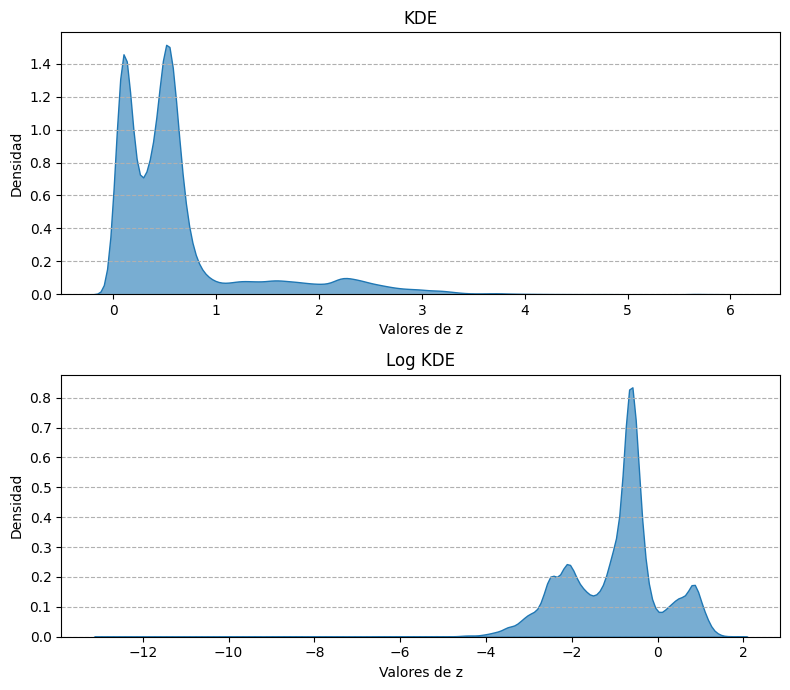

In [5]:
# Grafico KDE para el Redshift
plt.figure(figsize=(8, 7))
plt.subplot(2,1,1)
plt.title("KDE")
sns.kdeplot(data=df_150, x='z', fill=True, alpha=0.6)
plt.xlabel('Valores de z')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')

# Grafico KDE para el Redshift en log
plt.subplot(2,1,2)
plt.title("Log KDE")
sns.kdeplot(data=np.log(df_150), x='z', fill=True, alpha=0.6)
plt.xlabel('Valores de z')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
nombre_archivo = f"Distribucion_cielo.png"
plt.savefig(nombre_archivo, dpi=400, bbox_inches='tight')

## Graficos de Interpretacion

In [6]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(12, 7))
plt.subplot(2,2,1)
plt.title("KDE")
sns.kdeplot(data=df_150, x='expPhi_u', fill=True, alpha=0.6)
plt.xlabel('expPhi_u')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')

plt.subplot(2,2,2)
plt.title("Log KDE")
sns.kdeplot(data=np.log(df_150), x='expPhi_u', fill=True, alpha=0.6)
plt.xlabel('expPhi_u')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

plt.subplot(2,2,3)
plt.title("KDE")
sns.kdeplot(data=df_150, x='expRad_z', fill=True, alpha=0.6)
plt.xlabel('expRad_z')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')

plt.subplot(2,2,4)
plt.title("Log KDE")
sns.kdeplot(data=np.log(df_150), x='expRad_z', fill=True, alpha=0.6)
plt.xlabel('expRad_z')
plt.ylabel('Densidad')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

nombre_archivo = f"KDE_exp.png"
plt.savefig(nombre_archivo, dpi=400, bbox_inches='tight')
plt.close()

''' Nota: Transformar a logaritmo mejora considerablemente la forma de algunas distribuciones '''

' Nota: Transformar a logaritmo mejora considerablemente la forma de algunas distribuciones '

## Correlaciones

In [7]:
# Correlación de cada columna con z
corr_with_z = data.corr()["z"].sort_values(ascending=False)

corr_with_z.drop("z").plot(kind="bar", figsize=(10,5))
plt.title("Correlación de cada variable con redshift (z)")
plt.ylabel("Coeficiente de correlación")

nombre_archivo = f"Correlacion.png"
plt.savefig(nombre_archivo, dpi=400, bbox_inches='tight')
plt.close()

Podemos observar que las variables de magnitud se correlacionan bastante con z y que las de variables morfologicas se correlacionan de forma inversa, lo cual tiene sentido con la caracterizacion física.

## Variabilidad:

Para que nuestra red sea competente buscamos captar el mayor rango de variabilidad en los datos.

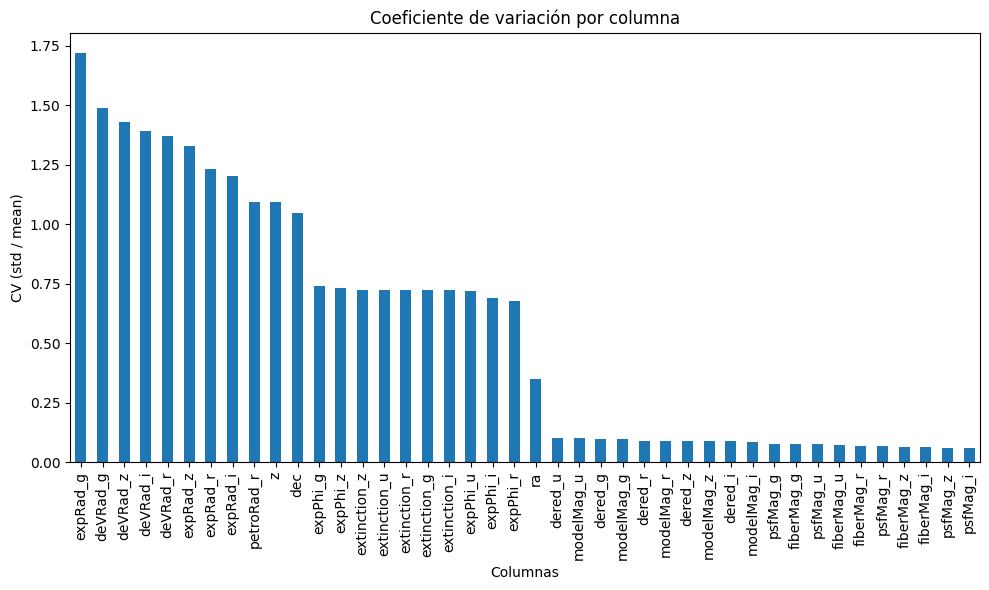

In [8]:
cv = data.std() / data.mean()

# Gráfico de barras: Coeficiente de variación
plt.figure(figsize=(10,6))
cv.sort_values(ascending=False).plot(kind="bar")
plt.title("Coeficiente de variación por columna")
plt.ylabel("CV (std / mean)")
plt.xlabel("Columnas")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Red Neuronal para estimar Redshift

* Entrenamiento y Validacion
* Testeo
* Analisis de overfitting, arquitectura, optimizer, dropout, tasa de aprendizaje, función de perdida
* Residuos
* Feature Importance
* Cuantificacion de error



## Ingenieria de Features

In [9]:
# Generamos variables de "color"
data['u_g'] = data['dered_u'] - data['dered_g']
data['g_r'] = data['dered_g'] - data['dered_r']
data['r_i'] = data['dered_r'] - data['dered_i']
data['i_z'] = data['dered_i'] - data['dered_z']

# Elegimos features

# Columnas Fijas
columnas_base = ['ra', 'dec', 'z','u_g', 'r_i','i_z']
# Filtramos por banda
columnas_banda = [col for col in data.columns if '_r' in col]
# Columnas Eliminadas
columnas_eliminar = ['dered_r', 'modelMag_r','expPhi_r','expRad_r']

columnas_final = columnas_base + columnas_banda

df = data[columnas_final].drop(columnas_eliminar, axis=1)

print('Datos: ', df.columns.tolist())


Datos:  ['ra', 'dec', 'z', 'u_g', 'r_i', 'i_z', 'deVRad_r', 'extinction_r', 'fiberMag_r', 'petroRad_r', 'psfMag_r', 'g_r']


In [10]:
# Transformamos a logaritmo
df_log = np.log(1 + df)

# Mascara de infinitos
mask_inf = df_log.isin([np.inf, -np.inf])
df_log[mask_inf] = (np.nan)

# Botamos Nans
df_log = df_log.dropna()

# Estandarizamos

scaler = StandardScaler()

datos_escalados = scaler.fit_transform(df_log)

df_escalado = pd.DataFrame(
    datos_escalados,
    columns=df_log.columns,
    index=df_log.index
)

X_df = df_escalado.drop(columns=['z'])  # Features
Y_df = df_escalado['z'] # Redshift

# Convertir a Tensores de PyTorch
X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y_df.values, dtype=torch.float32).unsqueeze(1)

# Crear un único TensorDataset
dataset = TensorDataset(X_tensor, Y_tensor)

# Hacemos los Splits con pytorch
Seed = 42
generator = torch.Generator().manual_seed(Seed)

# Calcular las Longitudes de las Divisiones (70%-15%-15%)
data_size = len(dataset)
Train_ratio = 0.70
Val_ratio = 0.15
Test_ratio = 0.15

# Cálculo de las longitudes, asegurando que sumen el total
train_len = int(Train_ratio * data_size)
val_len = int(Val_ratio * data_size)
test_len = data_size - train_len - val_len

lengths = [train_len, val_len, test_len]
print(f"Longitud total del Dataset: {data_size}")
print(f"Longitudes de los splits (Train, Val, Test): {lengths}")

# Realizar la División Random
train_set, val_set, test_set = random_split(
    dataset,
    lengths,
    generator=generator
)

print(f"Suma total: {len(train_set) + len(val_set) + len(test_set)}")

sample_X, _ = train_set[0]
input_features = sample_X.size(0)

print(f"Número de Características de Entrada (in_dim): {input_features}")

Longitud total del Dataset: 126256
Longitudes de los splits (Train, Val, Test): [88379, 18938, 18939]
Suma total: 126256
Número de Características de Entrada (in_dim): 11


## Modelo Pytorch

In [11]:
# Detecta GPU o CPU.
if torch.cuda.is_available():  # GPU disponible?
    device = torch.device("cuda")  # Usa CUDA
else:  # usa CPU
    device = torch.device("cpu")

## Definimos el modelo

In [12]:
class Coby(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

learning_rate = 0.001

model = Coby(in_dim=input_features).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Entrenamos y Validamos

In [14]:
NUM_EPOCHS = 2

# Define tus hiperparámetros de entrenamiento
BATCH_SIZE = 128
NUM_WORKERS = 4  # Número de procesos paralelos

train_losses = []
val_losses = []
best_val_loss = float('inf')

train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

val_loader = DataLoader(
dataset=val_set,
batch_size=BATCH_SIZE,
shuffle=False,
num_workers=NUM_WORKERS)


for epoch in range(NUM_EPOCHS):

# ------------- Entrenamiento --------------
    model.train()
    train_loss_sum = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # 1. Mover datos a la GPU (si aplica)
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)

        # 2. Pase hacia adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 3. Pase hacia atrás (Backward pass y Optimización)
        optimizer.zero_grad() # Limpia los gradientes acumulados de la iteración anterior
        loss.backward()       # Calcula los gradientes
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # max_norm es el umbral
        optimizer.step()      # Actualiza los pesos del modelo usando el optimizador

        train_loss_sum += loss.item() * inputs.size(0)

    avg_train_loss = train_loss_sum / len(train_loader.dataset)

    # Guardamos
    train_losses.append(avg_train_loss)

# ------------- Validacion --------------
    model.eval()
    val_loss_sum = 0.0

    # Desactivar el cálculo de gradientes
    with torch.no_grad():
        for inputs, labels in val_loader:

            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(inputs)

            labels = labels.float().view(-1, 1)

            # Calcular la pérdida de validación
            loss = criterion(outputs, labels)
            val_loss_sum += loss.item() * inputs.size(0)

    avg_val_loss = val_loss_sum / len(val_loader.dataset)
    # Guardamos
    val_losses.append(avg_val_loss)

# ------------- Seguimiento --------------

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')

    # Lógica para guardar el mejor modelo
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Guardar solo los pesos del modelo que tuvo el mejor rendimiento en validación
        torch.save(model.state_dict(), 'best_coby_model.pth')
        print("  -> ¡Mejor modelo guardado! ✅")


Epoch [1/2]
  Train Loss: 0.0910
  Validation Loss: 0.1112
  -> ¡Mejor modelo guardado! ✅
Epoch [2/2]
  Train Loss: 0.0899
  Validation Loss: 0.1214


In [15]:
# Cargamos los mejores modelos
model.load_state_dict(torch.load('best_coby_model.pth'))

# Para el conjunto de prueba
test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

# ------------- Testeo --------------
model.eval()

# 1. Inicializar listas para guardar resultados
all_predictions = []
all_targets = []

# 2. Desactivar el cálculo de gradientes
with torch.no_grad():
    for inputs, labels in test_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        # 2.1 Pase Forward (Predicción)
        outputs = model(inputs)

        # 2.2 Almacenar resultados
        all_predictions.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(labels.cpu().numpy().flatten())

# 3. Convertir a NumPy arrays para el cálculo de métricas
predictions = np.array(all_predictions)
targets = np.array(all_targets)

predictions = np.exp(predictions) - 1
targets = np.exp(targets) - 1

## Metricas y Residuos

Error Cuadrático Medio (MSE): 5.5475
Raíz del Error Cuadrático Medio (RMSE): 2.3553 (Unidades del Target)
Error Absoluto Medio (MAE): 0.5240 (Error promedio esperado)
Coeficiente de Determinación (R²): 0.6742
Desviación Estándar de los Residuales (Incertidumbre Estimada): ±2.3478


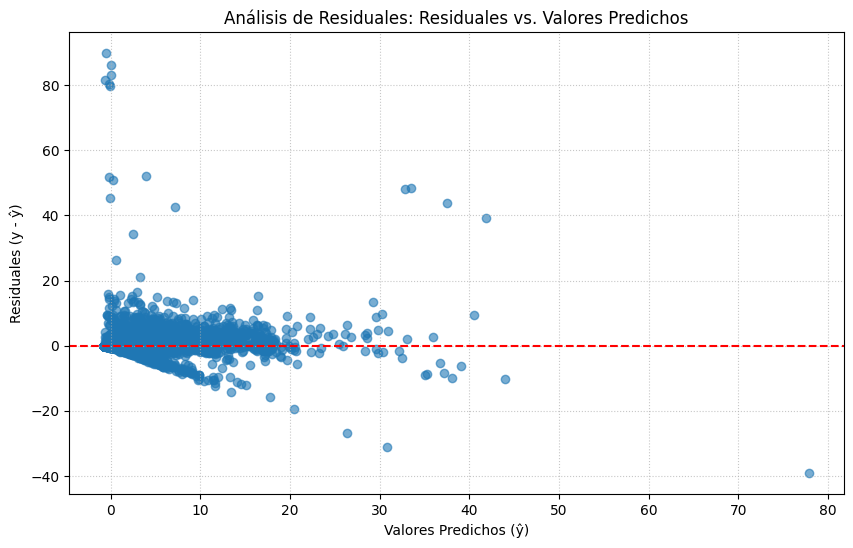

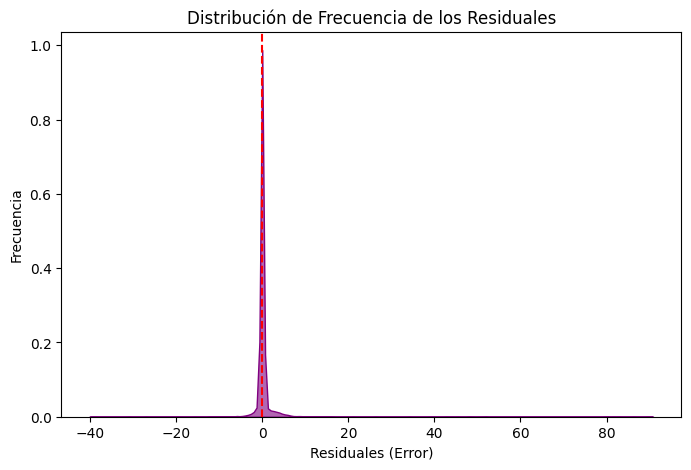

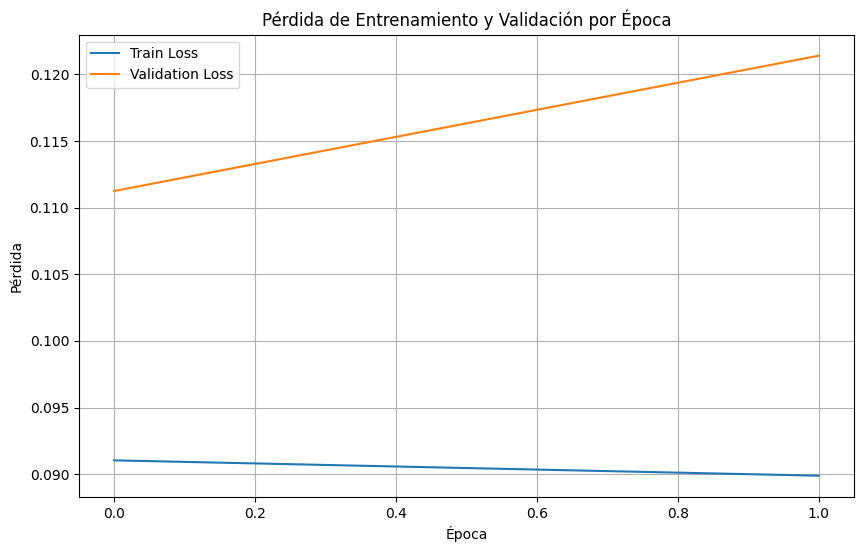

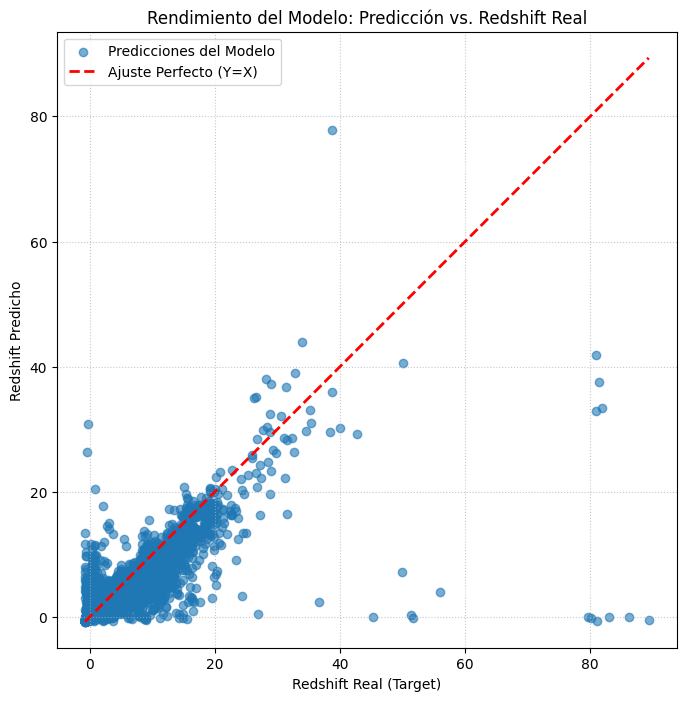

Skewness de los residuales: 18.3320
Kurtosis (en exceso) de los residuales: 597.1925


In [16]:
mse = mean_squared_error(targets, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, predictions)
r_squared = r2_score(targets, predictions)

print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f} (Unidades del Target)")
print(f"Error Absoluto Medio (MAE): {mae:.4f} (Error promedio esperado)")
print(f"Coeficiente de Determinación (R²): {r_squared:.4f}")

# Calcular los residuos (errores)
residuals = targets - predictions

# Calcular la desviación estándar de los residuales
uncertainty_estimate = np.std(residuals)

print(f"Desviación Estándar de los Residuales (Incertidumbre Estimada): ±{uncertainty_estimate:.4f}")

plt.figure(figsize=(10, 6))
# Scatter plot de los residuales contra los valores predichos
plt.scatter(predictions, residuals, alpha=0.6)

# Línea de referencia en y=0
plt.axhline(y=0, color='r', linestyle='--')

plt.title('Análisis de Residuales: Residuales vs. Valores Predichos')
plt.xlabel('Valores Predichos (ŷ)')
plt.ylabel('Residuales (y - ŷ)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 5))
# Graficar el histograma y la curva de densidad (KDE) de los residuales
sns.kdeplot(residuals, color='purple',fill=True, alpha=0.6)

plt.title('Distribución de Frecuencia de los Residuales')
plt.xlabel('Residuales (Error)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Pérdida de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 8))

# Gráfico de dispersión de los datos
plt.scatter(targets, predictions, alpha=0.6, label='Predicciones del Modelo')

min_val = min(targets.min(), predictions.min())
max_val = max(targets.max(), predictions.max())

# Genera una línea que va desde el valor mínimo al máximo con pendiente 1
plt.plot([min_val, max_val], [min_val, max_val],
         color='red',
         linestyle='--',
         linewidth=2,
         label='Ajuste Perfecto (Y=X)')

plt.title('Rendimiento del Modelo: Predicción vs. Redshift Real')
plt.xlabel('Redshift Real (Target)')
plt.ylabel('Redshift Predicho')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.axis('equal')
plt.show()

skn = skew(residuals)

curt = kurtosis(residuals)

print(f"Skewness de los residuales: {skn:.4f}")
print(f"Kurtosis (en exceso) de los residuales: {curt:.4f}")

In [17]:

def extract_and_convert(dataset_subset):
    """Extrae todos los datos y targets de un Subset de PyTorch y los convierte a NumPy."""
    data_list = []
    target_list = []

    for i in range(len(dataset_subset)):
        data, target = dataset_subset[i]
        data_list.append(data.cpu().numpy().flatten())
        target_list.append(target.cpu().numpy())

    X = np.stack(data_list)
    y = np.stack(target_list)
    return X, y

X_train, y_train = extract_and_convert(train_set)
X_val, y_val = extract_and_convert(val_set)
X_test, y_test = extract_and_convert(test_set)

X_test_df = pd.DataFrame(X_test)

# Guardamos infomacion del modelo

In [18]:
import os
import pickle

# Solicitar el nombre del modelo al usuario
model_name = input("Por favor, introduce el nombre del modelo (Ej: Coby_v1): ")

# Definir la ruta base: Resultados/NOMBRE_DEL_MODELO
BASE_PATH = os.path.join('Resultados', model_name)
os.makedirs(BASE_PATH, exist_ok=True)

print(f"\nGuardando resultados críticos en: '{BASE_PATH}'")

# 1. Archivo de Descripción (README)
readme_content = f"""# Registro del Experimento: {model_name}

## Configuración Principal
- Arquitectura: Coby (5 capas densas con ReLU con 128 N)
- Transformacion: Logaritmo
- Estandarizacion: Z-score (Standar_scale())
- Nombre del Modelo: {model_name}
- crit: {criterion}
- Semilla global (SEED): {Seed}
- Dimensión de Entrada (in_dim): {input_features}
- Epoch: {NUM_EPOCHS}
- Bach_size: {BATCH_SIZE}
- learn_rate: {learning_rate}
"""

# Guardar README en la carpeta del modelo
with open(os.path.join(BASE_PATH, 'README.md'), 'w') as f:
    f.write(readme_content)
print("- README.md (Descripción) guardado.")

# 2. Resultados (Métricas)
results_data = {
    'Metric': ['RMSE', 'MSE', 'MAE', 'R2', 'sigma'],
    'Value': [rmse, mse, mae, r_squared, uncertainty_estimate]
}

results_df = pd.DataFrame(results_data)
# Guardar CSV de métricas en la carpeta del modelo
results_df.to_csv(os.path.join(BASE_PATH, 'metrics.csv'), index=False)
print("- metrics.csv (Métricas) guardado.")

# 3. Momentos con agg o
moments_test = X_test_df.agg(['mean', 'var', 'skew', 'kurt'])
#moments_pred = predictions_df.agg(['mean', 'var', 'skew', 'kurt'])
#moments_df = X_test_df.pd_concat(moments_pred)
#moments_df.to_csv(os.path.join(BASE_PATH, 'moments.csv'), index=False)
#print("- moments.csv (Momentos) guardado.")

# 5. Gráfica de Entrenamiento (Train/Val Loss)
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Pérdida de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(BASE_PATH, 'train_val_loss.png'))
plt.close()
print("- train_val_loss.png (Gráfica de Pérdida) guardado.")

# Gráfica de Análisis de Residuales (Residuales vs Predichos)
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análisis de Residuales: Residuales vs. Valores Predichos')
plt.xlabel('Valores Predichos (ŷ)')
plt.ylabel('Residuales (y - ŷ)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig(os.path.join(BASE_PATH, 'Prediccion.png'))
plt.close()
print("- Prediccion.png (Residuales vs Predicciones) guardado.")

# Gráfica de Distribución de Residuales (Histograma/KDE)
plt.figure(figsize=(8, 5))
sns.kdeplot(residuals, color='purple',fill=True, alpha=0.6)
plt.title('Distribución de Frecuencia de los Residuales')
plt.xlabel('Residuales (Error)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--')
plt.savefig(os.path.join(BASE_PATH, 'Dist_residuos.png'))
plt.close()
print("- Dist_residuos.png (Distribución de Residuales) guardado.")

print("\nProceso finalizado. Solo los resultados clave fueron guardados.")

Por favor, introduce el nombre del modelo (Ej: Coby_v1): hola

Guardando resultados críticos en: 'Resultados/hola'
- README.md (Descripción) guardado.
- metrics.csv (Métricas) guardado.
- train_val_loss.png (Gráfica de Pérdida) guardado.
- Prediccion.png (Residuales vs Predicciones) guardado.
- Dist_residuos.png (Distribución de Residuales) guardado.

Proceso finalizado. Solo los resultados clave fueron guardados.
